In [1]:
import sys
import os

# Add your project root to sys.path (adjust the path below)
project_root = '/work/pi_shenoy_umass_edu/hshastri/FMaaS-motivation/timeseries/amazon-chronos/src'  # the folder containing 'momentfm'
if project_root not in sys.path:
    sys.path.insert(0, project_root)
os.chdir(f"/work/pi_shenoy_umass_edu/hshastri/FMaaS-motivation/timeseries/amazon-chronos/tasks")

In [2]:
from torch.utils.data import DataLoader
from momentfm.data.classification_dataset import ClassificationDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from typing import Tuple

import torch
from torch import nn
import os
import random
from argparse import Namespace
from typing import NamedTuple

import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import torch
from chronos import ChronosPipeline

/home/hshastri_umass_edu/.conda/envs/amazon-chronos/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from momentfm.data.anomaly_detection_dataset import AnomalyDetectionDataset
from torch.utils.data import DataLoader

train_dataset = AnomalyDetectionDataset(data_split='train', random_seed=13)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False, drop_last=False)
test_dataset = AnomalyDetectionDataset(data_split='test', random_seed=13)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=False)
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 98
Test dataset size: 154


In [4]:
model_name= "amazon/chronos-t5-small"
pipeline = ChronosPipeline.from_pretrained(
    f"{model_name}",
    device_map="cuda",
    torch_dtype=torch.bfloat16,)

output_dim_dir={"amazon/chronos-t5-tiny":256,"amazon/chronos-t5-mini":256,"amazon/chronos-t5-small":512,"amazon/chronos-t5-base":768,"amazon/chronos-t5-large":1024}

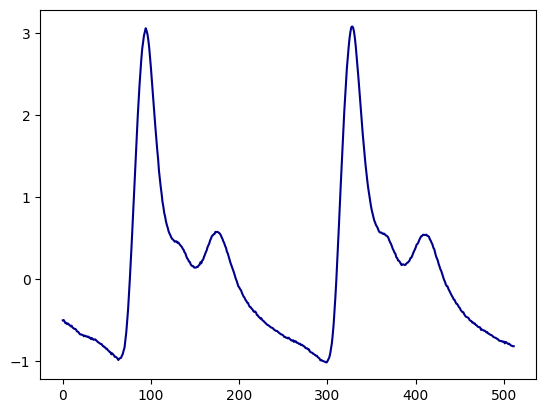

In [5]:
idx = np.random.randint(0, len(test_dataset))
plt.plot(test_dataset[idx][0].squeeze(), c='darkblue')
plt.show()

In [6]:
import torch.optim as optim
from momentfm.utils.masking import Masking

class ChronosHead(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.Dropout(p=0.1),
            nn.Linear(1024, output_dim)  # use output_dim = 1 for regression
        )

    def forward(self, x):
        return self.head(x)
    
model_dim = output_dim_dir[f'{model_name}']  # e.g., tiny=512, small=1024, base=2048
output_dim = 512   # regression (set to num_classes for classification)
head = ChronosHead(model_dim, output_dim)

# Optimize Mean Squarred Error using your favourite optimizer
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(head.parameters(), lr=1e-2)

mask_generator = Masking(mask_ratio=0.3)  
# 4. Training loop
head.train()
for epoch in range(100):
    epoch_loss = 0.0
    for batch_x, batch_masks,batch_labels in train_dataloader:
        n_channels = batch_x.shape[1]
        batch_x = batch_x.squeeze(1).to(torch.float32)
        mean = batch_x.mean(dim=1, keepdim=True)
        std = batch_x.std(dim=1, keepdim=True,unbiased=False) + 1e-6
        batch_x_norm = (batch_x - mean) / std  # shape: [B, 512]
        batch_x_norm = batch_x_norm.reshape((-1, 1, 512)) 
        
        batch_masks = batch_masks
        batch_masks = batch_masks.repeat_interleave(n_channels, axis=0)
        
        mask = mask_generator.generate_mask(batch_x_norm,input_mask=batch_masks)  # Generate mask for the batch
        corrupted_input = batch_x_norm.clone()
        corrupted_input[mask.unsqueeze(1) == 0] = 0.0
 
        # a. Get embeddings from Chronos
        with torch.no_grad():  # freeze Chronos
            output, tokenizer_state = pipeline.embed(corrupted_input.squeeze(1))
            embedding = output.mean(dim=1).to(torch.float32)
        pred = head(embedding)
        batch_x_norm=batch_x_norm.squeeze(1)

        # b. Compute loss
        recon_loss = (pred - batch_x_norm) ** 2  
        observed_mask = batch_masks * (1 - mask)
        masked_loss = observed_mask * recon_loss
        loss = masked_loss.nansum() / (observed_mask.nansum() + 1e-7)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Loss: {loss.item():.4f}")




Loss: 1.0011
Loss: 0.9617
Loss: 1.1942
Loss: 0.9762
Loss: 0.9164
Loss: 0.8545
Loss: 0.9426
Loss: 0.8427
Loss: 0.8965
Loss: 0.9368
Loss: 0.7683
Loss: 0.7068
Loss: 0.6501
Loss: 0.6132
Loss: 0.6547
Loss: 0.6687
Loss: 0.6192
Loss: 0.7130
Loss: 0.6386
Loss: 0.6417
Loss: 0.6310
Loss: 0.6289
Loss: 0.6388
Loss: 0.5737
Loss: 0.6436
Loss: 0.5845
Loss: 0.6493
Loss: 0.5547
Loss: 0.6678
Loss: 0.5713
Loss: 0.6331
Loss: 0.5558
Loss: 0.5166
Loss: 0.5618
Loss: 0.5231
Loss: 0.5615
Loss: 0.5754
Loss: 0.5126
Loss: 0.5886
Loss: 0.4994
Loss: 0.6156
Loss: 0.5236
Loss: 0.5625
Loss: 0.5008
Loss: 0.5417
Loss: 0.5139
Loss: 0.5148
Loss: 0.4606
Loss: 0.5492
Loss: 0.4424
Loss: 0.4953
Loss: 0.4454
Loss: 0.5346
Loss: 0.4229
Loss: 0.4998
Loss: 0.4914
Loss: 0.5622
Loss: 0.4672
Loss: 0.5300
Loss: 0.4618
Loss: 0.5270
Loss: 0.4531
Loss: 0.5504
Loss: 0.4520
Loss: 0.5389
Loss: 0.4992
Loss: 0.5349
Loss: 0.4793
Loss: 0.5378
Loss: 0.4311
Loss: 0.4833
Loss: 0.4593
Loss: 0.5021
Loss: 0.3735
Loss: 0.4630
Loss: 0.3639
Loss: 0.4837

In [7]:
torch.save(head.state_dict(), "chronos_head.pt")

In [8]:
# # Re-initialize the same model architecture
# head = ChronosHead(input_dim=512, output_dim=512)

# # Load the saved parameters
# head.load_state_dict(torch.load("chronos_head.pt"))

# # Set to eval mode if you're going to use it for inference
# head.eval()

In [9]:
import matplotlib.pyplot as plt

head.eval()
all_anomaly_scores = []
all_original = []
all_reconstructed = []
all_masks = []
all_labels= []

with torch.no_grad():
    for batch_x, batch_masks, batch_labels in tqdm(test_dataloader):
        batch_x = batch_x.squeeze(1).to(torch.float32)  # [B, 512]

        mean = batch_x.mean(dim=1, keepdim=True)
        std = batch_x.std(dim=1, keepdim=True, unbiased=False) + 1e-6
        batch_x_norm = (batch_x - mean) / std  # [B, 512]

        batch_x_norm = batch_x_norm.reshape((-1, 1, 512)) 
        batch_masks = batch_masks.long()
        batch_masks = batch_masks.repeat_interleave(n_channels, axis=0)

        # Mask valid entries only
        mask = mask_generator.generate_mask(batch_x_norm, input_mask=batch_masks).squeeze(1)

        corrupted_input = batch_x_norm.clone()
        corrupted_input[mask.unsqueeze(1) == 0] = 0.0
        
        # Embed and reconstruct
        with torch.no_grad():  # freeze Chronos
            output, tokenizer_state = pipeline.embed(corrupted_input.squeeze(1))
            embedding = output.mean(dim=1).to(torch.float32)
            
        pred = head(embedding)
        print(f"pred shape: {pred.shape}, batch_x shape: {batch_x.shape}, mask shape: {mask.shape}")

        pred=pred*std + mean 
        
        all_original.append(batch_x)
        all_reconstructed.append(pred)
        all_masks.append(mask)
        all_labels.append(batch_labels)
        


 33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  9.10it/s]

100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.03it/s]

pred shape: torch.Size([64, 512]), batch_x shape: torch.Size([64, 512]), mask shape: torch.Size([64, 512])
pred shape: torch.Size([64, 512]), batch_x shape: torch.Size([64, 512]), mask shape: torch.Size([64, 512])
pred shape: torch.Size([26, 512]), batch_x shape: torch.Size([26, 512]), mask shape: torch.Size([26, 512])


In [10]:
trues = np.concatenate(all_original, axis=0).flatten()
preds = np.concatenate(all_reconstructed, axis=0).flatten()
labels = np.concatenate(all_labels, axis=0).flatten()

# The last and the second to last windows have overlapping timesteps. We will remove these overlapping predictions
n_unique_timesteps = 512 - trues.shape[0] + test_dataset.length_timeseries
trues = np.concatenate([trues[:512*(test_dataset.length_timeseries//512)], trues[-n_unique_timesteps:]])
preds = np.concatenate([preds[:512*(test_dataset.length_timeseries//512)], preds[-n_unique_timesteps:]])
labels = np.concatenate([labels[:512*(test_dataset.length_timeseries//512)], labels[-n_unique_timesteps:]])
assert trues.shape[0] == test_dataset.length_timeseries

# We will use the Mean Squared Error (MSE) between the observed values and MOMENT's predictions as the anomaly score
anomaly_scores = (trues - preds)**2
print(labels)
print(anomaly_scores)

[0 0 0 ... 0 0 0]
[0.66192555 0.5668952  0.46475282 ... 0.0608351  0.07736997 0.08432087]


In [11]:

from momentfm.utils.anomaly_detection_metrics import adjbestf1
print(f"Zero-shot Adjusted Best F1 Score: {adjbestf1(y_true=labels, y_scores=anomaly_scores)}") 


Zero-shot Adjusted Best F1 Score: 0.9880332664340316


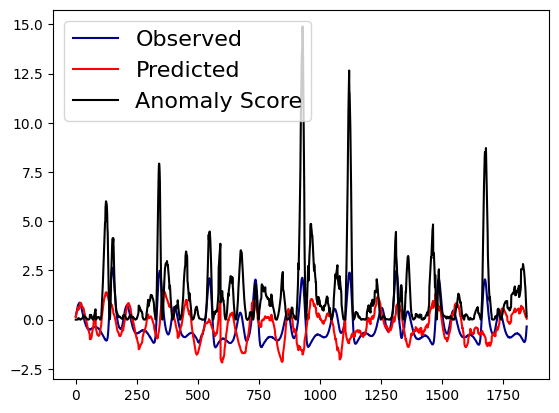

In [12]:
anomaly_start = 74158
anomaly_end = 74984
start = anomaly_start-512
end = anomaly_end+512

plt.plot(trues[start:end], label="Observed", c='darkblue')
plt.plot(preds[start:end], label="Predicted", c='red')
plt.plot(anomaly_scores[start:end], label="Anomaly Score", c='black')
plt.legend(fontsize=16)
plt.show()